## Numerical Integration Deep Dive and Quiz 4
Here, we consider the problem of numerically evaluating definite integrals
$$\int_a^b f(x) dx $$
and will mostly consider finite domains $-\infty < a < b < \infty$.
As with interpolation, we will be able to create very accurate and efficient methods for certain classes of functions while other functions will be more challenging.
For each integration technique we try, we're going to need to test its accuracy.
Let's create some test functions and their derivatives.


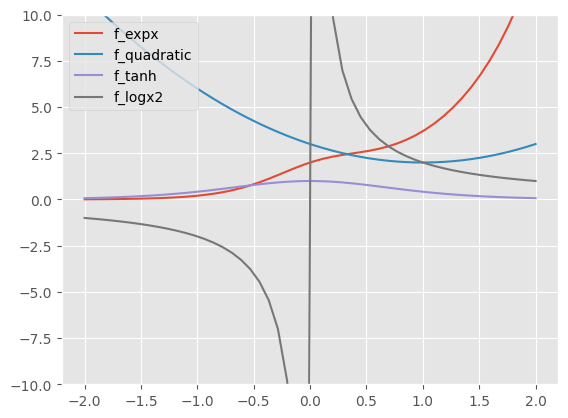

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

tests = []

@tests.append
class f_expx:
    def F(x):
        return np.exp(2*x)/(1+x**2)
    def f(x):
        return 2*np.exp(2*x)/(1+x**2) - np.exp(2*x)/(1+x**2)**2 * 2*x

@tests.append
class f_quadratic:
    def F(x):
        return x**3/3 - x**2 + 3*x - 1
    def f(x):
        return x**2 - 2*x + 3
    
@tests.append
class f_tanh:
    def F(x):
        return np.tanh(x)
    def f(x):
        return np.cosh(x)**(-2)
    
@tests.append
class f_logx2:
    def F(x):
        return np.log(x**2)
    def f(x):
        return 1/x**2 * 2*x

plt.rcParams['figure.max_open_warning'] = False
x = np.linspace(-2,2)
for t in tests:
    plt.plot(x, t.f(x), label=t.__name__)
plt.ylim(-10,10)
plt.legend(loc='upper left');

# Fundamental Theorem of Calculus 

## Fundamental Theorem of Calculus

Let $f(x)$ be a continuous function and define $F(x)$ by
$$ F(x) = \int_a^x f(s) ds . $$
Then $F(x)$ is uniformly continuous, differentiable, and
$$ F'(x) = f(x) . $$
We say that $F$ is an antiderivative of $f$.
This implies that
$$ \int_a^b f(x) dx = F(b) - F(a) . $$
We will test the accuracy of our integration schemes using an antiderivative provided in our tests.

### Method of Manufactured Solutions

Analytically integrating an arbitrary function is hard, tends to require trickery, and is not always possible to express in closed form (e.g., [elliptic integrals](https://en.wikipedia.org/wiki/Elliptic_integral)).  In contrast, analytic differentiation involves straightforward application of the product rule and chain rule.  So if we just choose an arbitrary function $F$ (the antiderivative), we can compute $f = F'$, then numerically integrate $\int_a^b f$ and compare to $F(b) - F(a)$.  We have used this technique to produce the `tests` array above.

## Newton-Cotes methods

Newton-Cotes methods approximate $f(x)$ using piecewise polynomial functions.  Polynomials are easy to integrate analytically so we need only sum up the integrals over each piecewise interval.

### Midpoint rule

The midpoint method uses piecewise constant functions over some number $n$ of intervals.

In [2]:
def fint_midpoint(f , a, b, n = 20):
    dx = (b-a)/n    # width of each interval 
    x  = np.linspace(a+dx/2, b-dx/2, n)
    return np.sum(f(x))*dx 

for t in tests: 
    a, b  = -2,2
    I = fint_midpoint(t.f, a, b , 20)
    print('{:12s}: I={: 10e} error={: 10e}'.
          format(t.__name__, I, I - (t.F(b) - t.F(a))))

f_expx      : I= 1.088552e+01 error=-3.044403e-02
f_quadratic : I= 1.732000e+01 error=-1.333333e-02
f_tanh      : I= 1.928508e+00 error= 4.523930e-04
f_logx2     : I= 9.769963e-15 error= 9.769963e-15


### How fast does our Method Converge? 


(0.0001, 20.02961285097817)

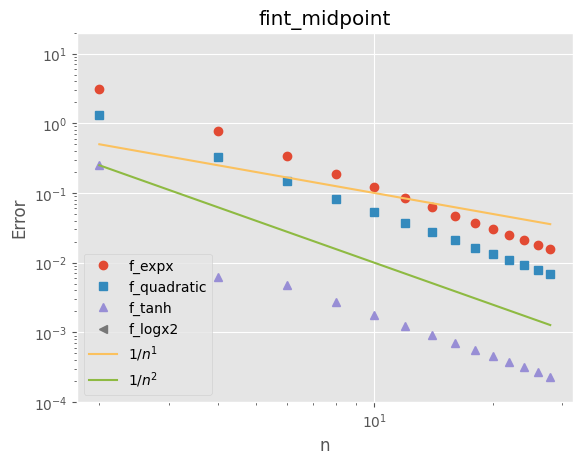

In [3]:
def plot_accuracy(fint, tests, ns, ref=[1,2], plot=plt.loglog):
    a, b = -2, 2
    ns = np.array(ns)
    plt.figure()
    symbol = iter(['o', 's', '^', '<', '*'])
    for t in tests:
        Is = np.array([fint(t.f, a, b, n) for n in ns])
        Errors = np.abs(Is - (t.F(b) - t.F(a)))
        plot(ns, Errors, next(symbol), label=t.__name__)
    for k in ref:
        plot(ns, 1/ns**k, label='$1/n^{:d}$'.format(k))
    plt.ylabel('Error')
    plt.xlabel('n')
    plt.legend(loc='lower left')
    plt.title(fint.__name__)
    
plot_accuracy(fint_midpoint, tests, range(2,30,2))
plt.ylim(1e-4)

## Measuring Cost 

### Measuring cost

A common situation with numerical integration is that the function $f(x)$ has a significant cost relative to the additions and multiplications needed to scale and sum the values.  The cost per integration point is constant for most methods that we will consider, therefore the number of function evaluations $n$ is a good measure of the cost.  Some algorithms may have higher cost per quadrature point in which case we will need to trade off the superlinear cost of quadrature with the linear cost of evaluating the function.

### Trapezoid Rule

The trapezoid rule uses piecewise linear functions on each interval.

$$\begin{split} \int_a^b f(a) + \frac{f(b) - f(a)}{b - a} (x - a) &= f(a) (x-a) + \frac{f(b) - f(a)}{2(b - a)} (x - a)^2 \Big|_{x=a}^b \\
&= f(a) (b-a) + \frac{f(b) - f(a)}{2(b - a)} (b-a)^2 \\
&= \frac{b-a}{2} \big( f(a) + f(b) \big) .
\end{split}

# Question 1 (10 points)

* Can you get to the same result using a geometric argument?  (5 points)

* What happens when we sum over a bunch of adjacent intervals? (5 points)

**Answer:**

- We can get the same result by multiplying the "overlap" between intervals (where the right endpoint of one interval is equal to the left endpoint of another) when summing. This way, we don't have to evaluate the function twice. 
- When we sum over multiple adjacent intervals, the right endpoint $b$ of one interval is equal to the left endpoint $a$ of another, creating an overlap. This overlap applies to all but the leftmost endpoint and the rightmost endpoint. 

In [4]:
x = np.linspace(-1,2,4)
print(x)
ix = [0,3]
print(x[ix])
print(x[[0,-1]])

[-1.  0.  1.  2.]
[-1.  2.]
[-1.  2.]


(0.0001, 104.58351239127549)

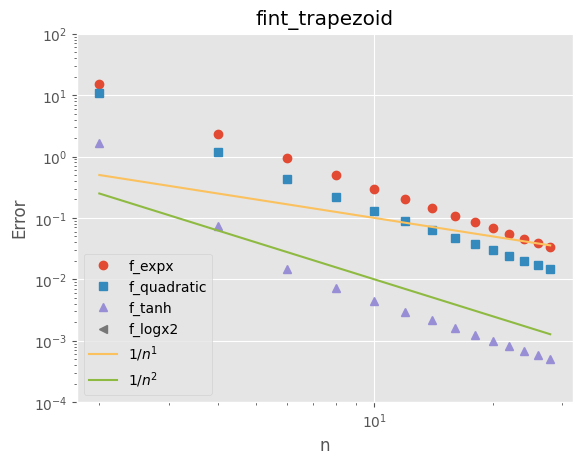

In [5]:
def fint_trapezoid(f, a, b, n = 20):
    dx  = (b-a) / (n-1)    # we evaluate endpoints of n-1 intervals 
    x  = np.linspace(a,b,n)
    fx = f(x)
    fx[[0,-1]] *= .5
    return np.sum(fx)*dx

plot_accuracy(fint_trapezoid, tests, range(2,30,2))
plt.ylim(1e-4)

In [6]:
for t in tests: 
    a, b = -2,2
    npoints = 10*2**np.arange(5)
    for n in npoints:
        I = fint_trapezoid(t.f, a, b , n)
        print('{:12s}: n={: 4d} I={: 10f} error={: 10f}'.
              format(t.__name__, n, I, I - (t.F(b) - t.F(a))))

f_expx      : n=  10 I= 11.215143 error=  0.299176
f_expx      : n=  20 I= 10.983499 error=  0.067532
f_expx      : n=  40 I= 10.932016 error=  0.016049
f_expx      : n=  80 I= 10.919879 error=  0.003913
f_expx      : n= 160 I= 10.916933 error=  0.000966
f_quadratic : n=  10 I= 17.465021 error=  0.131687
f_quadratic : n=  20 I= 17.362881 error=  0.029548
f_quadratic : n=  40 I= 17.340346 error=  0.007013
f_quadratic : n=  80 I= 17.335042 error=  0.001709
f_quadratic : n= 160 I= 17.333755 error=  0.000422
f_tanh      : n=  10 I=  1.923617 error= -0.004438
f_tanh      : n=  20 I=  1.927051 error= -0.001004
f_tanh      : n=  40 I=  1.927816 error= -0.000239
f_tanh      : n=  80 I=  1.927997 error= -0.000058
f_tanh      : n= 160 I=  1.928041 error= -0.000014
f_logx2     : n=  10 I=  0.000000 error=  0.000000
f_logx2     : n=  20 I=  0.000000 error=  0.000000
f_logx2     : n=  40 I=  0.000000 error=  0.000000
f_logx2     : n=  80 I=  0.000000 error=  0.000000
f_logx2     : n= 160 I= -0.0000

## Extrapolation 

Looking above, we observe that once we enter the asymptotic regime, errors appear to be monotonic. I.e, the error is either all positive or all negative, and the magnitute is cut by a factor of `4` on each double of the number of points $n$ 

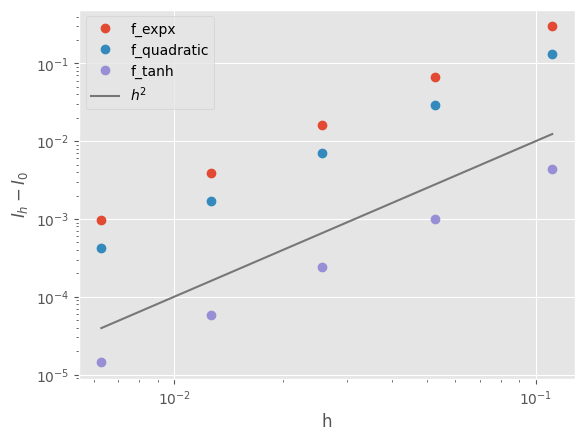

In [7]:
for t in tests[:-1]:
    h = 1/(npoints - 1)
    plt.loglog(h, [np.abs(fint_trapezoid(t.f, a,b,n)
                    - (t.F(b) - t.F(a)))
                    for n in npoints], 'o', label = t.__name__)
plt.loglog(h, h**2, label='$h^2$')
plt.xlabel('h')
plt.ylabel('$I_h - I_0$')
plt.legend(loc='upper left');

The trapezoid rule with $n$ points has an interval spacing of $h = 1/(n-1)$.  Let $I_h$ be the value of the integral approximated using an interval $h$.  We have numerical evidence that the leading error term is $O(h^2)$, i.e.,
$$ I_h - I_0 = c h^2 + O(h^3) $$
for some as-yet unknown constant $c$ that will depend on the function being integrated and the domain of integration.
If we can determine $c$ from two approximations, say $I_h$ and $I_{2h}$, then we can extrapolate to $h=0$.
For sufficiently small $h$, we can neglect $O(h^3)$ and write
$$\begin{split} I_h - I_0 &= c h^2 \\
I_{2h} - I_0 &= c (2h)^2 .
\end{split}$$
Subtracting these two lines, we have
$$ I_{h} - I_{2h} = c (h^2 - 4 h^2) $$
which can be solved for $c$ as
$$ c = \frac{I_{h} - I_{2h}}{h^2 - 4 h^2} . $$
Substituting back into the first equation, we solve for $I_0$ as
$$ I_0 = I_h - c h^2 = I_h + \frac{I_{h} - I_{2h}}{4 - 1} .$$
This is called **Richardson extrapolation**.

In [8]:
for t in tests[:-1]:
    a, b = -2, 2
    for n in [10, 20, 40, 80]:
        I_h = fint_trapezoid(t.f, a, b, n+1)
        I_2h = fint_trapezoid(t.f, a, b, n//2+1)
        I_extrap = I_h + (I_h - I_2h) / 3
        I_exact = t.F(b) - t.F(a)
        print('{:12s}: n={: 4d} error={: 10f} {: 10f} {: 10f}'.
              format(t.__name__, n, I_h-I_exact, I_2h-I_exact, I_extrap-I_exact))

f_expx      : n=  10 error=  0.242737   0.936372   0.011525
f_expx      : n=  20 error=  0.060958   0.242737   0.000365
f_expx      : n=  40 error=  0.015257   0.060958   0.000023
f_expx      : n=  80 error=  0.003815   0.015257   0.000001
f_quadratic : n=  10 error=  0.106667   0.426667   0.000000
f_quadratic : n=  20 error=  0.026667   0.106667   0.000000
f_quadratic : n=  40 error=  0.006667   0.026667   0.000000
f_quadratic : n=  80 error=  0.001667   0.006667   0.000000
f_tanh      : n=  10 error= -0.003602  -0.014480   0.000024
f_tanh      : n=  20 error= -0.000906  -0.003602  -0.000008
f_tanh      : n=  40 error= -0.000227  -0.000906  -0.000000
f_tanh      : n=  80 error= -0.000057  -0.000227  -0.000000


In [9]:
np.linspace(-1,1,11)

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [10]:
np.linspace(-1,1,6)

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

# Question 2 (5 points)

- Observations
- Sometimes extrapolation gives more accuracy than doubling the number of points
- The total Number of function evaluations is $n + n/2$

Can we get away with fewer function evaluations? 


**Answer:**

We can get away with fewer function evaluations by extrapolating the extrapolated points, giving us the same accuracy with fewer evaluations.

In [11]:
@tests.append
class f_sin10:
    def F(x):
        return np.sin(10*x)
    def f(x):
        return 10*np.cos(10*x)

/var/folders/_0/s734hct91wx3sx4zbn8z1s5w0000gn/T/ipykernel_50576/1069011732.py:34: RuntimeWarning: divide by zero encountered in divide
  return 1/x**2 * 2*x
/var/folders/_0/s734hct91wx3sx4zbn8z1s5w0000gn/T/ipykernel_50576/1069011732.py:34: RuntimeWarning: invalid value encountered in multiply
  return 1/x**2 * 2*x


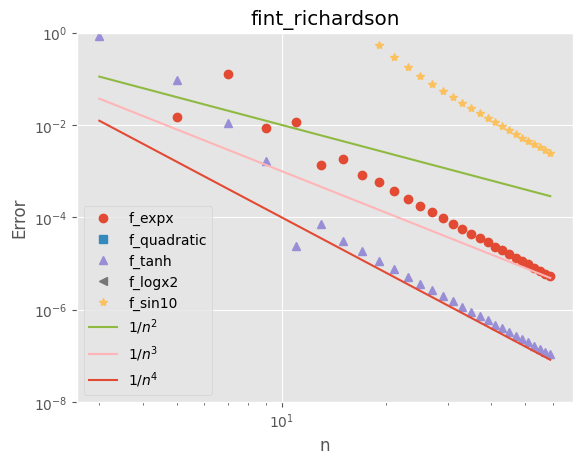

In [12]:
def fint_richardson(f, a, b, n):
    n = (n // 2) * 2 + 1
    h = (b - a) / (n - 1)
    x = np.linspace(a, b, n)
    fx = f(x)
    fx[[0,-1]] *= .5
    I_h = np.sum(fx)*h
    I_2h = np.sum(fx[::2])*2*h
    I_4h = np.sum(fx[::4])*4*h
    return I_h + (I_h - I_2h) / 3

plot_accuracy(fint_richardson, tests, range(3,60,2), ref=[2,3,4])
plt.ylim(1e-8, 1);

From above we observe that we created a *fourth order* accurate method by extrapolating a second order accurage method. This process can even be applied **recursively!!** 


# Gauss Quadrature 

## Gauss Quadrature (see class notes)

Recall the Legendre polynomials from the **Interpolation** unit.  These polynomials were orthogonal, so if we have a polynomial represented in the basis of Legendre polynomials, i.e.,
$$ p_n(x) = \sum_i c_i P_i(x) $$
where $P_i(x)$ is the $i$th Legendre polynomial, then
$$ \int_{-1}^1 p_n(x) = \int_{-1}^1 c_0 P_0(x) + c_1 P_1(x) + \dotsb = 2 c_0 . $$

* Given a set of points $\{x_i\}$, how can we determine $c_0$?

/var/folders/_0/s734hct91wx3sx4zbn8z1s5w0000gn/T/ipykernel_50576/1069011732.py:34: RuntimeWarning: divide by zero encountered in divide
  return 1/x**2 * 2*x
/var/folders/_0/s734hct91wx3sx4zbn8z1s5w0000gn/T/ipykernel_50576/1069011732.py:34: RuntimeWarning: invalid value encountered in multiply
  return 1/x**2 * 2*x


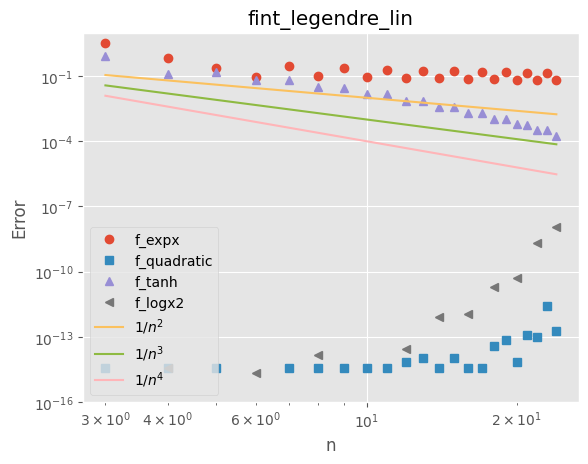

In [13]:
def vander_legendre(x, n=None):
    if n is None:
        n = len(x)
    P = np.ones((len(x), n))
    if n > 1:
        P[:,1] = x
    for k in range(1,n-1):
        P[:,k+1] = ((2*k+1) * x * P[:,k] - k * P[:,k-1]) / (k + 1)
    return P

def fint_legendre_lin(f, a, b, n):
    x = np.linspace(a, b, n)
    fx = f(x)
    P = vander_legendre(np.linspace(-1,1,n))
    c = np.linalg.solve(P, fx)
    return c[0] * (b-a)

plot_accuracy(fint_legendre_lin, tests[:-1], range(3,25), ref=[2,3,4])
plt.ylim(1e-16, 10);

### Observation - Pretty fast converge 

# Question (3) ( 5 points) 

We also observe erratic convergence. Why? 

**Answer:**

Erratic convergence occurs because of the limitations of linspace. This makes interpolation less stable, causing the integral to be less stable and creating erratic convergence.

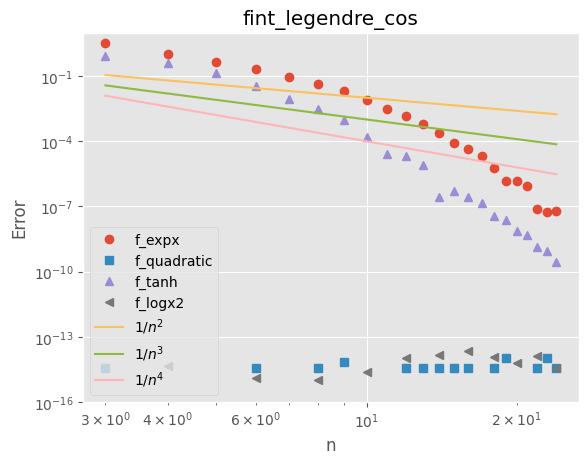

In [14]:
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (np.cos(np.linspace(0, np.pi, n)))

def fint_legendre_cos(f, a, b, n):
    x = cosspace(a, b, n)
    fx = f(x)
    P = vander_legendre(cosspace(-1,1,n))
    #c = np.linalg.solve(P, fx)
    w = np.linalg.inv(P)[0] * (b - a)
    return w @ f(x)

plot_accuracy(fint_legendre_cos, tests[:-1], range(3,25), ref=[2,3,4])
plt.ylim(1e-16, 10);

### Observations

This scheme fits the $n$ data points with an $n-1$ degree polynomial, thus is exact for integrating polynomials of degree $n-1$.  The leading error term is $O(h^n)$ where $h$ is the width of the interval.

To integrate a complicated function, one can either raise the degree $n$ or partition the interval $(a,b)$.

In `fint_legendre_cos`, we created the Vandermonde matrix $P$ in the Legendre basis.  But since we only need $c_0$, we could have written `c0 = inv(P)[0].dot(fx)` (just use the first row of $P^{-1}$).  In other words, our integration scheme is
$$ \int_{a}^b f(x) dx \approx (b-a) \sum_i w_i f(x_i) $$
where `w = inv(P)[0]`.  This set $\{x_i, w_i\}$ is called a quadrature.

### Doing better

We used the `cosspace` points because they make interpolation stable (versus `linspace`, for example).  We needed interpolation to be well-behaved for the integral of the interpolating function to be a good approximation.  But perhaps there are other stable points that could allow us to integrate higher degree polynomials.  To this end, suppose a polynomial on the interval $[-1,1]$ can be written as

$$ P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

# Question 4 (5 points)

* Why is $\int_{-1}^1 P_n(x) q(x) = 0$?

**Answer:**

As the degree of $q(x)$ is at most $n - 1$ and thus less than $n$, the integral is zero because of the properties of Legendre polynomials. 

# Question 5  (5 points) 

* Can every polynomials of degree $2n-1$ be written in the above form?

**Answer:**

If we divide a polynomial of degree $2n - 1$ by the nth Legendre Polynomial $P_n(x)$, we get a polynomial $q(x)$ and a polynomial $r(x)$, both of maximum degree $n - 1$. Because of this, all polynomials of degree $2n - 1$ can be written in the above form. 

# Question 6 (5 points) 

* How many roots does $P_n(x)$ have on the interval?

**Answer:**

As the roots of $P_n(x)$ are distinct and lie on the interval [-1, 1], $P_n(x)$ has n roots on the interval [-1, 1].

# Question 7 (5 points) 

* Can we choose points $\{x_i\}$ such that the first term is 0?

**Answer:**

Yes. If $x_i$ is a root of the Legendre polynomial, $P_n(x_i) q(x_i) = 0$ as $P_n(x_i) = 0$.


# Question 8 (10 points)

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?


**Answer:**

We can find the roots $x_i$ by computing them using Newton's Method as both Legendre Polynomials and their derivatives satisfy a recurrence. As the roots are distinct and symmetrical about the origin, and there are a set number of them, changing the initial guess is enough to find all roots $x_i$. 

#### Aside

$$ q(x) = c_0 P_0(x) + \dotsb + c_{n-1} P_{n-1}(x)$$

$$ \int_{-1}^1 P_n(x) \big(c_0 P_0(x) + \dotsb + c_{n-1} P_{n-1}(x) \big)$$
$$ \sum_{i=0}^{n-1} c_i \int_{-1}^1 P_n(x) P_i(x) $$

#### Derivatives of Legendre Polynomials

In the Interpolation unit, we learned that Legendre polynomials satisfy the recurrence
$$\begin{split}
P_0(x) &= 1 \\
P_1(x) &= x \\
(n+1) P_{n+1}(x) &= (2n+1) x P_n(x) - n P_{n-1}(x) .
\end{split}$$
It can also be shown that the derivatives satisfy a recurrence,
$$ P_{n+1}'(x) = (2n+1) P_n(x) + P_{n-1}'(x) . $$

With the ability to compute $P_n(x)$ and $P_n'(x)$, we can use Newton's method to compute the roots.
It turns out that `cos(linspace(.5/(n-1), 1-.5/(n-1), n) * pi)` is a good initial guess.

Below, I use the Golub-Welsch algorithm to compute the quadrature points and weights.

/var/folders/_0/s734hct91wx3sx4zbn8z1s5w0000gn/T/ipykernel_50576/1069011732.py:34: RuntimeWarning: divide by zero encountered in divide
  return 1/x**2 * 2*x
/var/folders/_0/s734hct91wx3sx4zbn8z1s5w0000gn/T/ipykernel_50576/1069011732.py:34: RuntimeWarning: invalid value encountered in multiply
  return 1/x**2 * 2*x


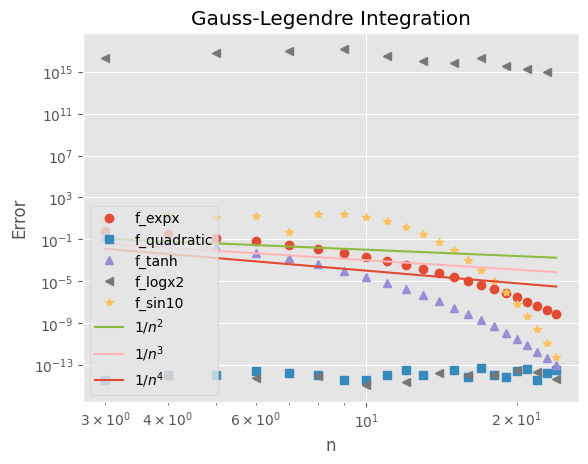

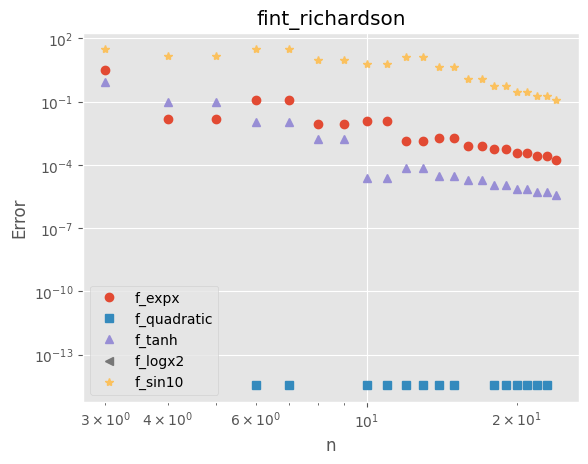

In [15]:
def fint_legendre(f, a, b, n):
    """Gauss-Legendre integration using Golub-Welsch algorithm"""
    beta = .5/np.sqrt(1-(2.*np.arange(1,n))**(-2))
    T = np.diag(beta,-1) + np.diag(beta, 1)
    D, V = np.linalg.eig(T)
    w = V[0,:]**2 * (b-a)
    x = (a+b)/2 + (b-a)/2 * D
    return w @ f(x)

plot_accuracy(fint_legendre, tests, range(3,25),
              ref=[2,3,4], plot=plt.loglog)
plt.title('Gauss-Legendre Integration')
plot_accuracy(fint_richardson, tests, range(3,25),
              ref=[], plot=plt.loglog)

In [16]:
fint_legendre(lambda x: (x-.5)**9, -1 ,1 , n = 5)\
                         - ((1-.5)**10/10 - (-1-.5)**10/10)

3.4638958368304884e-14